In [37]:
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Enabling the caching of data, so it doesn't need to get downloaded every time
fastf1.plotting.setup_mpl(color_scheme='fastf1')

In [38]:
fastf1.Cache.enable_cache('cache')
session = fastf1.get_session(2024, 'Saudi Arabia', 'R')
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


# Getting familiar with the data

In [46]:
lap = session.laps.pick_drivers('VER').pick_fastest()
tel = lap.get_telemetry()
print(len(tel['X']))

721


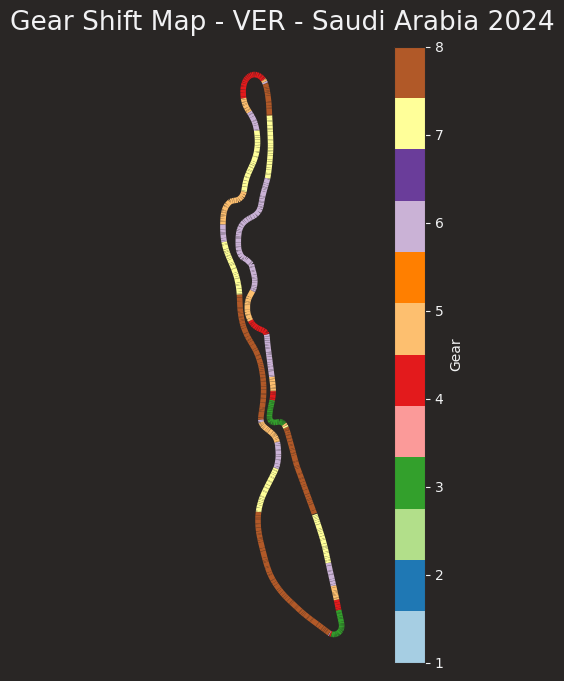

In [47]:
lap = session.laps.pick_drivers('VER').pick_fastest()
tel = lap.get_telemetry()

x = tel['X'].values
y = tel['Y'].values
gear = tel['nGear'].values.astype(float)

points = np.array([x,y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis = 1)

fig, ax = plt.subplots(figsize = (12, 8))

lc = LineCollection(segments, cmap = 'Paired', norm = plt.Normalize(1, 8))
lc.set_array(gear)
lc.set_linewidth(4)

ax.add_collection(lc)
ax.autoscale_view()

ax.axis('off')
ax.set_aspect('equal')
plt.title(f"Gear Shift Map - {lap['Driver']} - Saudi Arabia 2024")

cbar = plt.colorbar(lc, ticks = np.arange(1, 9))
cbar.set_label('Gear')
plt.show()
